## Telco Churn Project Notebook

In [15]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import sklearn.impute
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import env
import acquire

In [2]:
telco = acquire.get_telco_data()

In [3]:
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [4]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.872923,1.690473,0.162147,32.371149,64.761692
std,1.148907,0.737796,0.833755,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [6]:
# total_charges should be in the above .describe(), but it is the wrong dtype
telco.replace(to_replace = " ", value = np.nan, inplace = True)

In [7]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [8]:
# after attempts to change total_charges into a float, we discovered there is some empty space, so once we 
# replace those, we can now see a few missing values there, and we can change the dtype

# we will drop the 0 values from the data set, because we have plenty of data points for our analysis, and
# these customers haven't even had a chance to churn yet.

telco.dropna(axis = 0, inplace = True)

# now we change the dtype

telco.total_charges = telco.total_charges.astype('float')

In [9]:
# we'll rerun the .describe()

telco.describe()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,2.315557,1.872582,1.688567,0.162400,32.421786,64.798208,2283.300441
std,1.149523,0.737271,0.832934,0.368844,24.545260,30.085974,2266.771362
min,1.000000,1.000000,1.000000,0.000000,1.000000,18.250000,18.800000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.587500,401.450000
50%,2.000000,2.000000,1.000000,0.000000,29.000000,70.350000,1397.475000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.862500,3794.737500
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000,8684.800000


In [10]:
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.10,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.50,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [11]:
# We want to keep the customer_id, but we'd like to 'take it out' of the data for future scaling,
# exploration, etc. So, we will set the index with the customer_id

# set index to customer_id:

telco.set_index('customer_id', inplace=True)

In [12]:
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,2,1,1,Male,0,No,No,9,Yes,Yes,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check
0013-MHZWF,4,1,1,Female,0,No,Yes,9,Yes,No,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
0015-UOCOJ,1,1,1,Female,1,No,No,7,Yes,No,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
0023-HGHWL,1,1,1,Male,1,No,No,1,No,No phone service,...,No,No,No,Yes,25.1,25.10,Yes,Month-to-month,DSL,Electronic check
0032-PGELS,3,1,1,Female,0,Yes,Yes,1,No,No phone service,...,No,No,No,No,30.5,30.50,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [13]:
telco['tenure_years'] = telco.tenure/12
telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,2,1,1,Male,0,No,No,9,Yes,Yes,...,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check,0.750000
0013-MHZWF,4,1,1,Female,0,No,Yes,9,Yes,No,...,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic),0.750000
0015-UOCOJ,1,1,1,Female,1,No,No,7,Yes,No,...,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check,0.583333
0023-HGHWL,1,1,1,Male,1,No,No,1,No,No phone service,...,No,No,Yes,25.1,25.10,Yes,Month-to-month,DSL,Electronic check,0.083333
0032-PGELS,3,1,1,Female,0,Yes,Yes,1,No,No phone service,...,No,No,No,30.5,30.50,Yes,Month-to-month,DSL,Bank transfer (automatic),0.083333


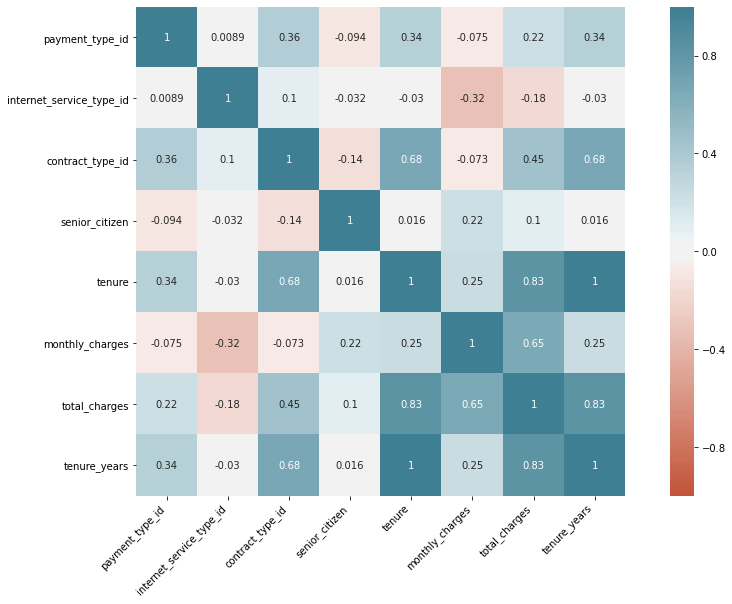

In [25]:
corr = telco.corr()

plt.figure(figsize=(16,9))

ax = sns.heatmap(
    corr,
    annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [26]:
# we have a ton of variables, so we're looking to combine a few columns into single 'encoded' variables
# here we're looking at whether a customer has phone service at all, and if they do do they have 1 or more lines
# so we'll put a 0 for none, 1 for yes, but 1 line, 2 for yes and more than 1 line

phone_service = [0 if i == 'No' else 1 for i in telco.phone_service]
multiple_lines = [1 if i == 'Yes' else 0 for i in telco.multiple_lines]

telco['phone_and_multi_line'] = [phone_service[i] + multiple_lines[i] for i in range(len(phone_service))]

In [27]:
# here we're addressing a similar issue to the phone and multi-line columns. We will look at the dependent and
# partner columns. With these we'll address them similar to before, 0 for 'no and no', 1 for 'yes and no', 2 for
# 'no and yes', and 3 for 'yes and yes'.

# we add all of that to and empty list, then turn that into a new column

partner_and_dependents = []

for i in range(len(telco.partner)):
    if telco.partner[i] == 'No' and telco.dependents[i] == 'No':
        partner_and_dependents.append(0)
    elif telco.partner[i] == 'Yes' and telco.dependents[i] == 'No':
        partner_and_dependents.append(1)
    elif telco.partner[i] == "No" and telco.dependents[i] == 'Yes':
        partner_and_dependents.append(2)
    elif telco.partner[i] == 'Yes' and telco.dependents[i] == 'Yes':
        partner_and_dependents.append(3)

telco['partner_and_dependents'] = partner_and_dependents

In [28]:
telco.head(10)

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,phone_and_multi_line,partner_and_dependents
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,2,1,1,Male,0,No,No,9,Yes,Yes,...,No,59.90,542.40,No,Month-to-month,DSL,Mailed check,0.750000,2,0
0013-MHZWF,4,1,1,Female,0,No,Yes,9,Yes,No,...,Yes,69.40,571.45,No,Month-to-month,DSL,Credit card (automatic),0.750000,1,2
0015-UOCOJ,1,1,1,Female,1,No,No,7,Yes,No,...,Yes,48.20,340.35,No,Month-to-month,DSL,Electronic check,0.583333,1,0
0023-HGHWL,1,1,1,Male,1,No,No,1,No,No phone service,...,Yes,25.10,25.10,Yes,Month-to-month,DSL,Electronic check,0.083333,0,0
0032-PGELS,3,1,1,Female,0,Yes,Yes,1,No,No phone service,...,No,30.50,30.50,Yes,Month-to-month,DSL,Bank transfer (automatic),0.083333,0,3
0067-DKWBL,1,1,1,Male,1,No,No,2,Yes,No,...,Yes,49.25,91.10,Yes,Month-to-month,DSL,Electronic check,0.166667,1,0
0076-LVEPS,2,1,1,Male,0,No,Yes,29,No,No phone service,...,Yes,45.00,1242.45,No,Month-to-month,DSL,Mailed check,2.416667,0,2
0082-LDZUE,2,1,1,Male,0,No,No,1,Yes,No,...,Yes,44.30,44.30,No,Month-to-month,DSL,Mailed check,0.083333,1,0
0096-BXERS,1,1,1,Female,0,Yes,No,6,Yes,Yes,...,No,50.35,314.55,No,Month-to-month,DSL,Electronic check,0.500000,2,1


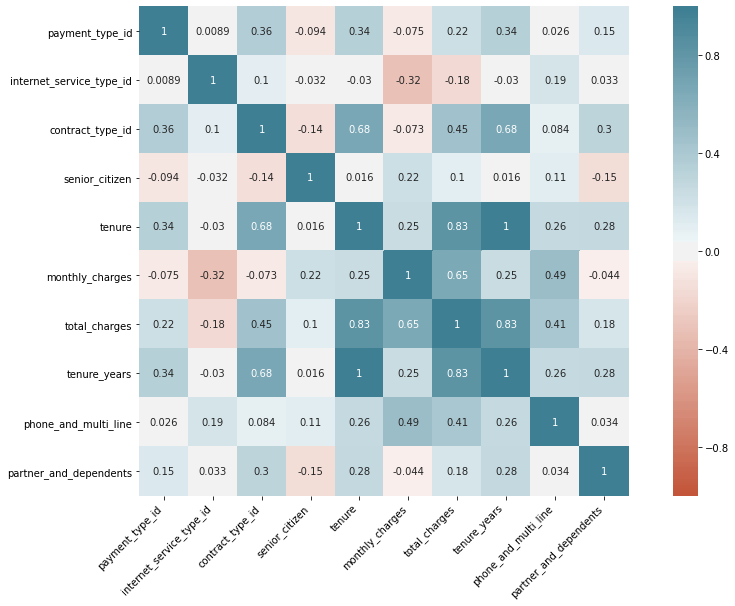

In [29]:
corr = telco.corr()

plt.figure(figsize=(16,9))

ax = sns.heatmap(
    corr,
    annot = True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [34]:
# we feel that dropping the type_id fields for payment, internet_service, and contract becuase these are
# artifacts of the joining process during SQL pull

telco = telco.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'])

In [35]:
telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,phone_and_multi_line,partner_and_dependents
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,...,No,59.9,542.40,No,Month-to-month,DSL,Mailed check,0.750000,2,0
0013-MHZWF,Female,0,No,Yes,9,Yes,No,No,No,No,...,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic),0.750000,1,2
0015-UOCOJ,Female,1,No,No,7,Yes,No,Yes,No,No,...,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check,0.583333,1,0
0023-HGHWL,Male,1,No,No,1,No,No phone service,No,No,No,...,Yes,25.1,25.10,Yes,Month-to-month,DSL,Electronic check,0.083333,0,0
0032-PGELS,Female,0,Yes,Yes,1,No,No phone service,Yes,No,No,...,No,30.5,30.50,Yes,Month-to-month,DSL,Bank transfer (automatic),0.083333,0,3


In [75]:
# we're drop the columns partner, dependents, phone_service, tenure, and multiple_lines, because we've added 'encoded'
# versions on the dataframe

telco = telco.drop(columns=['partner', 'dependents', 'phone_service', 'tenure', 'multiple_lines'])

KeyError: "['partner' 'dependents' 'phone_service' 'multiple_lines'] not found in axis"

In [67]:
telco.sample(5)

,gender,senior_citizen,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years,phone_and_multi_line,partner_and_dependents
customer_id,,,,,,,,,,,,,,,,,,,
0318-QUUOB,Male,0,1,No,No,No,No,Yes,No,Yes,80.55,80.55,Yes,Month-to-month,Fiber optic,Electronic check,0.083333,1,1
4676-WLUHT,Male,0,54,Yes,Yes,No,No,No,Yes,No,46.20,2431.95,No,Two year,DSL,Bank transfer (automatic),4.500000,0,0
9801-GDWGV,Female,0,39,No,Yes,Yes,No,Yes,Yes,Yes,103.45,3994.45,Yes,Month-to-month,Fiber optic,Electronic check,3.250000,2,0
6630-UJZMY,Female,1,4,No,No,No,No,Yes,No,Yes,83.25,308.05,No,Month-to-month,Fiber optic,Electronic check,0.333333,2,1
6210-KBBPI,Male,1,9,No,Yes,No,No,Yes,Yes,Yes,99.45,919.40,Yes,Month-to-month,Fiber optic,Credit card (automatic),0.750000,2,0


In [62]:
# now we need to encode our data for numerous columns: payment, internet_service, and contract_type
# we will use the one hot encoder because we're not 'ranking' the different options.
# they are categorical in nature

one_hot = OneHotEncoder(categories = 'auto', sparse = False)
payment_encoded = one_hot.fit_transform(telco[['payment_type']])

labels = list(np.array(telco.payment_type.value_counts().index))

payment_encoded_df = pd.DataFrame(payment_encoded, columns = labels, index = telco.index)

In [63]:
payment_encoded_df.head()

,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic)
customer_id,,,,
0003-MKNFE,0.0,0.0,0.0,1.0
0013-MHZWF,0.0,1.0,0.0,0.0
0015-UOCOJ,0.0,0.0,1.0,0.0
0023-HGHWL,0.0,0.0,1.0,0.0
0032-PGELS,1.0,0.0,0.0,0.0


In [64]:
# next we'll one hot encode the internet service

one_hot = OneHotEncoder(categories = 'auto', sparse = False)
internet_encoded = one_hot.fit_transform(telco[['internet_service_type']])

labels = list(telco.internet_service_type.value_counts().sort_index().index)

internet_encoded_df = pd.DataFrame(internet_encoded, columns = labels, index = telco.index)

In [65]:
internet_encoded_df.head()

,DSL,Fiber optic,None
customer_id,,,
0003-MKNFE,1.0,0.0,0.0
0013-MHZWF,1.0,0.0,0.0
0015-UOCOJ,1.0,0.0,0.0
0023-HGHWL,1.0,0.0,0.0
0032-PGELS,1.0,0.0,0.0


In [69]:
# last we'll encode the contract type

one_hot = OneHotEncoder(categories = 'auto', sparse = False)
contract_encoded = one_hot.fit_transform(telco[['contract_type']])

labels = list(telco.contract_type.value_counts().sort_index().index)

contract_encoded_df = pd.DataFrame(contract_encoded, columns = labels, index = telco.index)

In [71]:
contract_encoded_df.head()

,Month-to-month,One year,Two year
customer_id,,,
0003-MKNFE,1.0,0.0,0.0
0013-MHZWF,1.0,0.0,0.0
0015-UOCOJ,1.0,0.0,0.0
0023-HGHWL,1.0,0.0,0.0
0032-PGELS,1.0,0.0,0.0


In [72]:
# now that all the one hot encoded dataframes are ready to go, we need to join them to the orginal dataframe

telco = telco.join([payment_encoded_df, internet_encoded_df, contract_encoded_df])

In [79]:
telco.head()

,gender,senior_citizen,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,...,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic),DSL,Fiber optic,None,Month-to-month,One year,Two year
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,Male,0,9,No,No,No,No,No,Yes,No,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
0013-MHZWF,Female,0,9,No,No,No,Yes,Yes,Yes,Yes,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0015-UOCOJ,Female,1,7,Yes,No,No,No,No,No,Yes,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0023-HGHWL,Male,1,1,No,No,No,No,No,No,Yes,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0032-PGELS,Female,0,1,Yes,No,No,No,No,No,No,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [80]:
telco.shape

(7032, 29)

In [81]:
telco.columns

Index(['gender', 'senior_citizen', 'tenure', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type', 'tenure_years', 'phone_and_multi_line',
       'partner_and_dependents', 'Electronic check', 'Mailed check',
       'Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Fiber optic', 'None', 'Month-to-month', 'One year', 'Two year'],
      dtype='object')

In [83]:
telco = telco.drop(columns=['contract_type', 'internet_service_type', 'payment_type'])

In [84]:
telco.head()

,gender,senior_citizen,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,...,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic),DSL,Fiber optic,None,Month-to-month,One year,Two year
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,Male,0,9,No,No,No,No,No,Yes,No,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
0013-MHZWF,Female,0,9,No,No,No,Yes,Yes,Yes,Yes,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0015-UOCOJ,Female,1,7,Yes,No,No,No,No,No,Yes,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0023-HGHWL,Male,1,1,No,No,No,No,No,No,Yes,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0032-PGELS,Female,0,1,Yes,No,No,No,No,No,No,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [85]:
pd.set_option('display.max_columns', None)

In [95]:
telco.sample(20)

,gender,senior_citizen,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years,phone_and_multi_line,partner_and_dependents,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic),DSL,Fiber optic,None,Month-to-month,One year,Two year
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,
6461-PPAXN,Female,0,35,2,No,No,Yes,No,No,Yes,54.95,1916.00,No,2.916667,1,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9274-UARKJ,Female,0,15,0,Yes,No,No,Yes,No,Yes,83.20,1130.00,No,1.250000,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2674-MIAHT,Female,0,4,0,Yes,No,No,No,No,Yes,80.30,324.20,No,0.333333,2,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6893-ODYYE,Male,0,50,2,Yes,Yes,Yes,No,No,Yes,90.10,4549.45,No,4.166667,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6860-YRJZP,Male,1,9,0,No,No,No,No,No,Yes,74.05,678.45,No,0.750000,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2257-BOVXD,Male,0,14,0,No,No,Yes,Yes,No,Yes,66.60,979.50,No,1.166667,2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1269-FOYWN,Male,0,44,1,No internet service,No internet service,No internet service,No internet service,No internet service,No,20.00,860.85,No,3.666667,1,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8276-MQBYC,Male,1,51,0,No,Yes,No,Yes,Yes,Yes,97.80,4913.30,Yes,4.250000,2,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4629-NRXKX,Female,0,2,0,No,No,No,No,No,No,70.40,147.15,Yes,0.166667,1,3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [87]:
telco.shape

(7032, 26)

In [92]:
encoder = LabelEncoder()
encoder.fit_transform(telco[['online_security']])

telco.online_security = encoder.transform(telco[['online_security']])

In [93]:
telco.head()

,gender,senior_citizen,tenure,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years,phone_and_multi_line,partner_and_dependents,Electronic check,Mailed check,Bank transfer (automatic),Credit card (automatic),DSL,Fiber optic,None,Month-to-month,One year,Two year
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,Male,0,9,0,No,No,No,No,Yes,No,59.9,542.40,No,0.750000,2,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
0013-MHZWF,Female,0,9,0,No,No,Yes,Yes,Yes,Yes,69.4,571.45,No,0.750000,1,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0015-UOCOJ,Female,1,7,2,No,No,No,No,No,Yes,48.2,340.35,No,0.583333,1,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0023-HGHWL,Male,1,1,0,No,No,No,No,No,Yes,25.1,25.10,Yes,0.083333,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
0032-PGELS,Female,0,1,2,No,No,No,No,No,No,30.5,30.50,Yes,0.083333,0,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
def int_encode(df):
    le = LabelEncoder()
    encoded = le.fit_transform(df)
    encoded = pd.DataFrame(encoded)
    return encoded